In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr
import itertools
from sklearn.cross_decomposition import CCA
import networkx as nx
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def get_windows(job,n_neighbors):
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)


In [5]:
save_path = 'G:/HuBMAP/B008_12/analysis/CRC_analysis/'
cells = pd.read_csv("G:/HuBMAP/B008_12/Neighborhoods/05_25_HuBMAP_tunit.csv", index_col=0)
cells.reset_index(inplace=True, drop=True)

#pat:treat
cells['patients'] = cells['donor']+'_'+cells['tissue']
cells['patients'].unique()

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (62,63,70) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


NameError: name 'cells2' is not defined

In [8]:
neigh_num = {list(cells['Neighborhood'].unique())[i]:i for i in range(len(cells['Neighborhood'].unique()))}
cells['neigh_num'] = cells['Neighborhood'].map(neigh_num)
cells['neigh_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [9]:
#Choose this information and input based on above
ks = [10,] # k=5 means it collects 5 nearest neighbors for each center cell

X = 'x'
Y = 'y'
reg = 'unique_region'

cluster_col = 'Cell Type'
cellhier_path = 'G:/cellhier'
keep_cols = [X,Y,reg,cluster_col]

#Import Data
n_neighbors = max(ks)
sys.path.append(cellhier_path)
from cellhier.general import *

cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],1)
sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values

In [10]:
#Get each region
tissue_group = cells[[X,Y,reg]].groupby(reg)
exps = list(cells[reg].unique())
tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]

Starting: 1/64 : B004_Ascending
Finishing: 1/64 : B004_Ascending 0.11831021308898926 0.1222994327545166
Starting: 9/64 : B004_Descending
Finishing: 9/64 : B004_Descending 0.10831403732299805 0.23212456703186035
Starting: 49/64 : B004_Descending - Sigmoid
Finishing: 49/64 : B004_Descending - Sigmoid 0.08204388618469238 0.3161635398864746
Starting: 17/64 : B004_Duodenum
Finishing: 17/64 : B004_Duodenum 0.147385835647583 0.46454906463623047
Starting: 25/64 : B004_Ileum
Finishing: 25/64 : B004_Ileum 0.08791589736938477 0.5554571151733398
Starting: 34/64 : B004_Mid-jejunum
Finishing: 34/64 : B004_Mid-jejunum 0.11661219596862793 0.6730666160583496
Starting: 41/64 : B004_Proximal Jejunum
Finishing: 41/64 : B004_Proximal Jejunum 0.10536813735961914 0.7810308933258057
Starting: 57/64 : B004_Transverse
Finishing: 57/64 : B004_Transverse 0.10967564582824707 0.8917040824890137
Starting: 2/64 : B005_Ascending
Finishing: 2/64 : B005_Ascending 0.05761146545410156 0.951310396194458
Starting: 10/64 : B

In [11]:
#Loop over k to compute neighborhoods
out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):

        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)
        
windows = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window],1)
    windows[k] = window

In [12]:
#Fill in based on above
k = 10
n_neighborhoods = 30
neighborhood_name = "neighborhood"+str(k)
k_centroids = {}

In [13]:
#producing what to plot
windows2 = windows[k]
windows2[cluster_col] = cells[cluster_col]

km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

labels = km.fit_predict(windows2[sum_cols].values)
k_centroids[k] = km.cluster_centers_
cells[neighborhood_name] = labels
cells

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


,MUC2,SOX9,MUC1,CD31,Synapto,CD49f,CD15,CHGA,CDX2,ITLN1,...,NK,Nerve,Neuroendocrine,Neutrophil,Paneth,Plasma,Smooth muscle,Stroma,TA,neighborhood10
0,-0.303994,-0.163727,-0.587608,-0.212903,0.164173,-0.664863,0.049305,0.003616,-0.377532,-0.450794,...,1,0,0,0,0,0,0,0,0,2
1,-0.301927,-0.491706,-0.500804,-0.243205,-0.142568,-0.664861,-0.182627,-0.117573,-0.182754,-0.236199,...,1,0,0,0,0,0,0,0,0,2
2,-0.302206,-0.547234,-0.510705,-0.235309,-0.217185,-0.622758,-0.296486,-0.091504,-0.268055,-0.355383,...,1,0,0,0,0,0,0,0,0,8
3,-0.294644,-0.615593,-0.570580,-0.247548,-0.042246,-0.642230,-0.299031,-0.121458,-0.377533,-0.450797,...,1,0,0,0,0,0,0,0,0,11
4,-0.298609,-0.272162,-0.587607,-0.228376,-0.266695,-0.664864,-0.237499,-0.121460,-0.168489,-0.430944,...,1,0,0,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511997,0.251624,-0.360296,-0.254984,-0.229060,0.154796,-0.218688,-0.350372,-0.112132,-0.142597,-0.352178,...,0,0,0,0,0,0,0,0,0,16
2511998,-0.274299,-0.465097,-0.367546,-0.210402,-0.204488,-0.259962,-0.333110,-0.103590,-0.213387,-0.342405,...,0,0,0,0,0,0,0,0,0,27
2511999,-0.260292,-0.397157,-0.352751,-0.200957,0.427470,-0.061012,-0.363492,-0.109572,-0.172711,-0.357500,...,0,0,0,0,0,0,0,0,0,1
2512000,-0.073782,-0.020896,-0.365204,-0.102411,-0.218278,-0.266579,-0.337989,-0.103707,-0.072134,-0.328749,...,0,0,0,0,0,0,0,0,0,18


In [14]:
#cells = pd.read_pickle('cells2_salil')
patient_to_group_dict = cells.loc[:,['patients','tissue']].drop_duplicates().set_index('patients').to_dict()['tissue']
group1_patients = [a for a,gp in patient_to_group_dict.items() if gp=='SB']
group2_patients = [a for a,gp in patient_to_group_dict.items() if gp=='CL']
group1_patients

['B004_SB',
 'B005_SB',
 'B006_SB',
 'B009_SB',
 'B011_SB',
 'B012_SB',
 'B010_SB',
 'B008_SB']

In [15]:
cells['Cell Type'].unique()

array(['NK', 'Enterocyte', 'MUC1+ Enterocyte', 'TA', 'CD66+ Enterocyte',
       'Paneth', 'Smooth muscle', 'M1 Macrophage', 'Goblet',
       'Neuroendocrine', 'CD57+ Enterocyte', 'Lymphatic', 'CD8+ T', 'DC',
       'M2 Macrophage', 'B', 'Neutrophil', 'Endothelial', 'Cycling TA',
       'Plasma', 'CD4+ T cell', 'Stroma', 'Nerve', 'ICC', 'CD7+ Immune'],
      dtype=object)

In [19]:
# select which neighborhoods and functional subsets
cns = list(cells['neigh_num'].unique())
subsets = ['CD8+ T']

In [20]:
#log (1e-3 +  neighborhood specific cell type frequency) of functional subsets) ('nsctf')
nsctf = np.log(1e-3 + cells.groupby(['patients','neigh_num'])[subsets].mean().reset_index().set_index(['neigh_num','patients']))

# CCA relative to permutations for group1

In [21]:
cca = CCA(n_components=1,max_iter = 5000)
func = pearsonr

# set number of permutation params
n_perms = 5000
stats_group1 = {}

for cn_i in cns:
    for cn_j in cns:
        if cn_i < cn_j:

            #concat dfs
            combined = pd.concat([nsctf.loc[cn_i].loc[nsctf.loc[cn_i].index.isin(group1_patients)],nsctf.loc[cn_j].loc[nsctf.loc[cn_j].index.isin(group1_patients)]], axis = 1).dropna(axis = 0, how = 'any')
            if combined.shape[0]<2:
                continue
            x = combined.iloc[:,:len(subsets)].values
            y = combined.iloc[:,len(subsets):].values

            arr = np.zeros(n_perms)

            #compute the canonical correlation achieving components with respect to observed data
            ccx,ccy = cca.fit_transform(x,y)
            stats_group1[cn_i,cn_j] = (pearsonr(ccx[:,0],ccy[:,0])[0],arr)

            #initialize array for perm values

            for i in range(n_perms):
                idx = np.arange(len(x))
                np.random.shuffle(idx)
                # compute with permuted data
                cc_permx,cc_permy = cca.fit_transform(x[idx],y)
                arr[i] = pearsonr(cc_permx[:,0],cc_permy[:,0])[0]





### visualization

In [23]:
#For Neighborhood 2
neigh_dict =  {
 'Transit Amplifying Zone': 'darkblue',
 'Microvasculature': 'black',
 'Adaptive Immune Enriched': 'orange',
 'Glandular Epithelial': 'darkorange',
 'CD66+ Mature Epithelial': 'firebrick',
 'Stroma & Innate Immune': 'brown',
 'CD8+ T Enriched IEL': 'green',
 'Mature Epithelial': 'magenta',
 'Innate Immune Enriched': 'skyblue',
 'Outer Follicle': 'navy',
 'Plasma Cell Enriched': 'yellow',
 'Innervated Stroma': 'blueviolet',
 'Stroma': 'gray',
 'Macrovasculature': 'gold',
 'Secretory Epithelial': 'yellowgreen',
 'Smooth Muscle': 'red',
 'Innervated Smooth Muscle': 'lightgreen',
 'Inner Follicle': 'blue',
 'Smooth Muscle & Innate Immune': 'tan',
 'Paneth Enriched': 'lightblue'}
dict_new = {}
for k in neigh_num.keys():
    dict_new[neigh_num[k]]=neigh_dict[k]
pal = list(dict_new.values())
dict_new

{0: 'magenta',
 1: 'darkblue',
 2: 'skyblue',
 3: 'navy',
 4: 'orange',
 5: 'yellowgreen',
 6: 'firebrick',
 7: 'yellow',
 8: 'brown',
 9: 'tan',
 10: 'black',
 11: 'blueviolet',
 12: 'blue',
 13: 'darkorange',
 14: 'green',
 15: 'gold',
 16: 'red',
 17: 'lightblue',
 18: 'gray',
 19: 'lightgreen'}

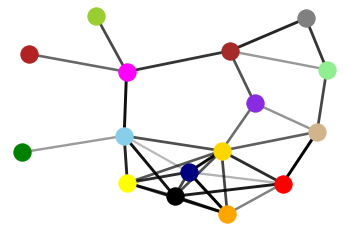

In [24]:
g1 = nx.Graph()
for cn_pair, cc in stats_group1.items():
    s,t = cn_pair
    obs, perms = cc
    p =np.mean(obs>perms)
    if p>0.9 :
        g1.add_edge(s,t, weight = p)
    
    
#pal = sns.color_palette('bright',10)
dash = {True: '-', False: ':'}
pos=nx.drawing.nx_pydot.pydot_layout(g1,prog='neato')
for k,v in pos.items():
    x,y = v
    plt.scatter([x],[y],c = [pal[k]], s = 300,zorder = 3)
    #plt.text(x,y, k, fontsize = 10, zorder = 10,ha = 'center', va = 'center')
    plt.axis('off')


atrs = nx.get_edge_attributes(g1, 'weight')    
for e0,e1 in g1.edges():
    p = atrs[e0,e1]
    plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], c= 'black',alpha = 3*p**3,linewidth = 3*p**3)

    
#plt.savefig(save_path+'T_cca_neigh_Tcell.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


# CCA relative to permutations for group2

In [25]:
cca = CCA(n_components=1,max_iter = 5000)
func = pearsonr

# set number of permutation params
n_perms = 5000
stats_group2 = {}

for cn_i in cns:
    for cn_j in cns:
        if cn_i < cn_j:

            #concat dfs
            combined = pd.concat([nsctf.loc[cn_i].loc[nsctf.loc[cn_i].index.isin(group2_patients)],nsctf.loc[cn_j].loc[nsctf.loc[cn_j].index.isin(group2_patients)]], axis = 1).dropna(axis = 0, how = 'any')
            if combined.shape[0]<2:
                continue
            x = combined.iloc[:,:len(subsets)].values
            y = combined.iloc[:,len(subsets):].values

            arr = np.zeros(n_perms)

            #compute the canonical correlation achieving components
            ccx,ccy = cca.fit_transform(x,y)
            stats_group2[cn_i,cn_j] = (pearsonr(ccx[:,0],ccy[:,0])[0],arr)

            #initialize array for perm values

            for i in range(n_perms):
                idx = np.arange(len(x))
                np.random.shuffle(idx)
                cc_permx,cc_permy = cca.fit_transform(x[idx],y)
                arr[i] = pearsonr(cc_permx[:,0],cc_permy[:,0])[0]





### visualization

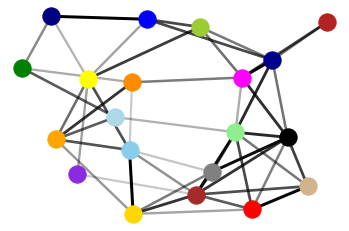

In [26]:
g2 = nx.Graph()
for cn_pair, cc in stats_group2.items():
    s,t = cn_pair
    obs, perms = cc
    p =np.mean(obs>perms)
    if p>0.9 :
        g2.add_edge(s,t, weight = p)
    
    
#pal = sns.color_palette('bright',10)
dash = {True: '-', False: ':'}
pos=nx.drawing.nx_pydot.pydot_layout(g2,prog='neato')
for k,v in pos.items():
    x,y = v
    plt.scatter([x],[y],c = [pal[k]], s = 300,zorder = 3)
    #plt.text(x,y+10, k, fontsize = 20, zorder = 10,ha = 'center', va = 'center')
    plt.axis('off')

atrs = nx.get_edge_attributes(g2, 'weight')    
for e0,e1 in g2.edges():
    p = atrs[e0,e1]
    plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], c= 'black',alpha = 3*p**3,linewidth = 3*p**3)
    

#plt.savefig(save_path1+'2HC_cca_neigh_Tcell.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


In [18]:
neigh_num

{'Immune Infiltrate': 0,
 'Productive T Cell Tumor Interface': 1,
 'Ki67+ Tumor': 2,
 'Unproductive T Cell Tumor Interface': 3,
 'CD117hi Tumor & Neutrophil': 4,
 'Tumor': 5,
 'Mixed Tumor': 6}